In [1]:
import mxnet as mx
import os, urllib
import logging
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple
import numpy as np

%matplotlib inline

head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

In [2]:
dshape = [('data', (1,3,224,224))]

def load_model(s_fname, p_fname):
    """
    Load model checkpoint from file.
    :return: (arg_params, aux_params)
    arg_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's weights.
    aux_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's auxiliary states.
    """
    symbol = mx.symbol.load(s_fname)
    save_dict = mx.nd.load(p_fname)
    arg_params = {}
    aux_params = {}
    for k, v in save_dict.items():
        tp, name = k.split(':', 1)
        if tp == 'arg':
            arg_params[name] = v
        if tp == 'aux':
            aux_params[name] = v
    return symbol, arg_params, aux_params

model_symbol = "caffenet-mxnet-jump-start-bootstrap-symbol.json"
model_params = "caffenet-mxnet-jump-start-bootstrap-0010.params"
sym, arg_params, aux_params = load_model(model_symbol, model_params)
mod = mx.mod.Module(symbol=sym)

# bind the model and set training == False; Define the data shape
mod.bind(for_training=False, data_shapes=dshape)
mod.set_params(arg_params, aux_params)

/home/srip_face/.local/lib/python2.7/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [13]:
Batch = namedtuple('Batch', ['data'])

def preprocess_image(img, show_img=False):
    '''
    convert the image to a numpy array
    '''
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    return img

v_dir = '/data3/yingwei/vidDB/diving_share/firstphase/video_first10/RWNrARSbRCY_000.mp4'
# v_dir = '/data3/yingwei/vidDB/diving_share/firstphase/video_first10/cYkUl8MrXgA_190.mp4'
scores = []
times = []
cap = cv2.VideoCapture(v_dir)
if cap.isOpened():
    fps = cap.get(5)
    step = int(fps/4.0)
    c = 0
    cap.set(1,0)
    while True:
        ret = cap.grab()
        if not ret:
            break
        if c%step != 0:
            c += 1
            continue
        ret, frame = cap.retrieve()
        if not ret:
            break
        img = preprocess_image(frame)
        mod.forward(Batch([mx.nd.array(img)]))
        
        # predict
        prob = mod.get_outputs()[0].asnumpy()
        scores.append(prob[0][1].copy())
        times.append(c/fps)
        c += 1

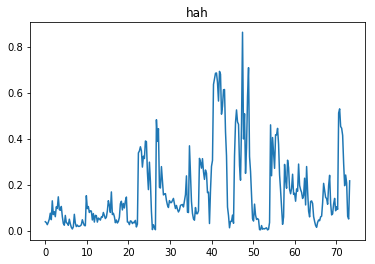

In [19]:
plt.plot(times, scores)
plt.title('')

In [15]:
cap.set(1,0)
ret,frame = cap.read()
height, width, channels = frame.shape

# Define the codec and create VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'xvid') # Be sure to use lower case
fourcc = cv2.cv.CV_FOURCC(*'xvid')
out = cv2.VideoWriter(v_dir.split('/')[-1].split('.')[0]+'_bootstrap.avi', fourcc, 5.0, (width, height))

In [16]:
for i,itm in enumerate(scores):
    cap.set(1,times[i]*fps)
    ret,frame = cap.read()
    if not ret:
        continue
    if itm>0.5:
        cv2.putText(frame, "{0:.2f}".format(itm), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,255),2)
    else:
        cv2.putText(frame, "{0:.2f}".format(itm), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,255),2)
    out.write(frame)

In [17]:
out.release()